# Workshop 2: Linearizing the Equations of Motion
In this tutorial you will learn to linearize the Equations of Motion of the pendulum as covered in the lecture. 

In [68]:
# for time comparison later
import time
start_time = time.time()

## Part 1: Kinematic equations

We first start by defining the variables. Let's start with the kinematic relations of a pendulum hanging from the point $(x_1, z_1)$. Note that the horizontal coordinate x is defined with a cosine, indicating that the angle is defined counter-clockwise starting from the horizontal. A hanging pendulum thus has $\phi_1 = \frac{-\pi}{2} = \frac{3\pi}{2}$.

In [69]:
from sympy import *
var("t x1 z1 r phi0") # independent variables      
phi1 = Function("phi1")(t)
x2 = x1 + r*cos(phi1)
z2 = z1 + r*sin(phi1)

The velocities can then be obtained using:

In [70]:
xdot = diff(x2, t)
zdot = diff(z2, t)

## Part 2: Energy equations
### Kinetic energy:
The in this system is $m$, such that the kinetic energy is given by:

In [71]:
var("m")
T = 0.5*m*(xdot**2 + zdot**2)
T.evalf()

0.5*m*(r**2*sin(phi1(t))**2*Derivative(phi1(t), t)**2 + r**2*cos(phi1(t))**2*Derivative(phi1(t), t)**2)

This expression can be simplified to:

In [72]:
T = simplify(T) # Linearization
T.evalf()

0.5*m*r**2*Derivative(phi1(t), t)**2

### Potential energy:
The potential energy on the pendulum is due to gravity:

In [73]:
var("g")
V = m*g*z2
V.evalf()

g*m*(r*sin(phi1(t)) + z1)

## Step 3: Construct the Lagrangian

In [74]:
L = T - V
L.evalf()

-g*m*(r*sin(phi1(t)) + z1) + 0.5*m*r**2*Derivative(phi1(t), t)**2

## Step 4: Obtaining the EoM

In order to obtain the EoMs we have to take derivatives w.r.t. $\phi_1$ and its velocity. 

In [75]:
EOM_phi = diff( diff(L, diff(phi1, t)), t) - diff(L, phi1)
# ! LHS needs derivative to get "velocity"
EOM_phi = simplify(EOM_phi)
EOM_phi.evalf()

m*r*(g*cos(phi1(t)) + 1.0*r*Derivative(phi1(t), (t, 2)))

The equation is nonlinear since it depends on the cosine of the angle. We want to obtain a linear function, so let's linearize. We consider a perturbation around the point we want to linearize ($\phi_0$). We linearize with the following function substitution: $\phi_1(t) = \phi_0 + \epsilon \psi(t)$. The $\epsilon$ is added in order to apply the Taylor series expansion. 

On a technical note: Using SymPy for function substitution can be tricky, hence we will use temporary symbols called `tmp1` and `tmp2` in order to do the substitution.

In [76]:
var("phi0 epsilon")
psi = Function("psi")(t) # perturbation function

tmp1 = symbols("tmp1")
EOM_psi = EOM_phi.evalf(subs={phi1: tmp1})
EOM_psi = EOM_psi.evalf(subs={tmp1: phi0 + epsilon*psi})
print(EOM_psi)
EOM_psi.evalf()

m*r*(g*cos(epsilon*psi(t) + phi0) + 1.0*r*Derivative(epsilon*psi(t) + phi0, (t, 2)))


m*r*(g*cos(epsilon*psi(t) + phi0) + 1.0*r*Derivative(epsilon*psi(t) + phi0, (t, 2)))

Now, we can apply the Taylor series expansion using the function $\epsilon$ as a variable.

In [77]:
EOM_lin = series(EOM_psi, epsilon, n=2)
EOM_lin.evalf()

1.0*m*r**2*Derivative(phi0, (t, 2)) + g*m*r*cos(phi0) + epsilon*(-g*m*r*psi(t)*sin(phi0) + 1.0*m*r**2*Derivative(psi(t), (t, 2))) + O(epsilon**2)

Note that we know that $\frac{d^2\phi_0}{dt^2}=0$, so we can redefine the derivative in terms of $\psi$ only.

In [78]:
tmp2 = symbols("tmp2")
EOM_psi2 = EOM_phi.evalf(subs={diff(phi1, (t, 2)): tmp2, phi1: tmp1})
EOM_psi2 = EOM_psi2.evalf(subs={tmp2: diff(phi0 + epsilon*psi, (t, 2)), tmp1: phi0 + epsilon*psi})
EOM_psi2.evalf()

m*r*(1.0*epsilon*r*Derivative(psi(t), (t, 2)) + g*cos(epsilon*psi(t) + phi0))

In [79]:
EOM_lin = series(EOM_psi2, epsilon, n=2)
EOM_lin.evalf()

g*m*r*cos(phi0) + epsilon*(-g*m*r*psi(t)*sin(phi0) + 1.0*m*r**2*Derivative(psi(t), (t, 2))) + O(epsilon**2)

Then, we obtain the linearized EOM by setting $\epsilon = 1$.

In [80]:
EOM_lin = EOM_lin.removeO().evalf(subs={epsilon: 1})
EOM_lin.evalf()

-g*m*r*psi(t)*sin(phi0) + g*m*r*cos(phi0) + 1.0*m*r**2*Derivative(psi(t), (t, 2))

We see that we get an expression that only depends on (linearly) on the perturbation $\psi(t)$. Isolating the second derivative with respect to time of the perturbation, we get the final expression of the linearized system.

In [81]:
EOM_lin_iso = solve(EOM_lin, diff(psi, (t, 2)))
EOM_lin_iso[0].evalf()

g*(psi(t)*sin(phi0) - cos(phi0))/r

In this problem, our initial angle is $\phi_0 = 3*\frac{\pi}{2}$, then the final Equation of Motion will be:

In [82]:
a = EOM_lin_iso[0].evalf(subs={phi0: 3*pi/2})
a

-g*psi(t)/r

In [83]:
end_time = time.time()

## Part 3: Solve the equation

Now we can solve the equation using an ODE solver

In [84]:
tsym, psisym = symbols("tsym psisym")
print(a)
a = a.evalf(subs={t: tsym, psi: psisym, g: 9.81, r: 1.0})
print(a)
def qdot(t,q):
    vt = q[1]
    at = a.evalf(subs={psisym: q[0], tsym: t})
    return [vt,at]

-g*psi(t)/r
-9.81*psisym


In [85]:
# Just for demonstration
qdot(0,[0,0])

[0, 0]

In [86]:
from scipy.integrate import solve_ivp
sol = solve_ivp(fun=qdot,t_span=[0,10],y0=[1,0])
# Note: The initial "angle" of 1 would not be considered small, so the linearization would in practice not be physically accurate.

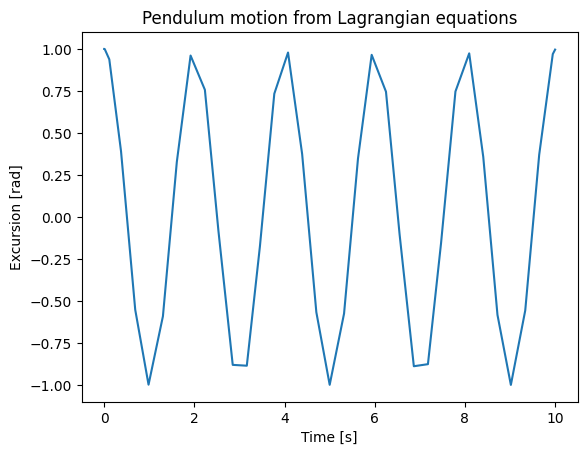

In [87]:
import matplotlib.pyplot as plt
plt.plot(sol.t,sol.y[0])
plt.xlabel("Time [s]")
plt.ylabel("Excursion [rad]")
plt.title("Pendulum motion from Lagrangian equations");

## Part 4: Performance comparison

In [88]:
print(end_time-start_time)

1.537172794342041


Depending on the machine you are running on the execution of this notebook takes anywhere from 1 tin a few seconds. For the development of this tutorial a TU Delft issue HP Zbook G5 was used, carrying an i7-8750H CPU at 2.2 GHz with 16 GB of 64 bit RAM. The notebook took 1.64 seconds to execute.

An alternative way of doing symbolic calculations is through the use of [Maplesoft](https://maplesoft.com/). Below you can see an example of a Maple math file that performs the same calculations as in this notebook from the `start_time` to the `end_time`. This gives, as shown below, an execution time of 2.256. While Maple can be more intuitive for symbolic manipulations, it becomes clear that the computional cost of the sympy package is rather good.

<center><img src="https://github.com/rdeke/ComModHOS_double/blob/main/book/images/Module2/Maple/w2_t1_MapleExample.png?raw=true" width="400"/></center>

## Part 5: Exercise

Now it is time to applied what you have learned. Using the tutorial above, try to construct, and then solve the following problem:
- A mass-spring-damper system with a point mass of 200 kg at the end.
- A spring with spring-stiffness 10 kN/m.
- A damper with damping force 1 kN s/m.
- An external force defined as (in kN) $F(t) = 10 \sin(\pi t)$.

*Hint*: How would you implement the energy dissipation from the dashpot? <br>

<center><img src="https://github.com/rdeke/ComModHOS_double/blob/main/book/images/Module2/w2_t1_mcksystem.png?raw=true" width="400" /></center>

-------------------------------------------------------------------------------------
[The solution can be found here.](Workshop_Linearizing_EOM_sol.ipynb)